In [19]:
import os
import shutil
import random
from PIL import Image
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune import Checkpoint
import tempfile

from typing import Tuple

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
SEED = 42

## Data split

In [22]:
image_paths = []
labels = []

classes = {v: i for i, v in enumerate(sorted(os.listdir('Vehicles/')))}

for root, _, files in os.walk('Vehicles/'):
    label = os.path.basename(root)
    if label in classes:
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                image_paths.append(os.path.join(root, file))
                labels.append(label)

X_train, X_test, y_train, y_test = train_test_split(
    image_paths, labels, test_size=0.2, random_state=SEED, stratify=labels
)

for split_name, paths, split_labels in [('train', X_train, y_train), 
                                         ('test', X_test, y_test)]:
    for path, label in zip(paths, split_labels):
        dest_dir = os.path.join('Vehicles_split', split_name, label)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy2(path, os.path.join(dest_dir, os.path.basename(path)))

DATA_DIR = os.path.abspath('Vehicles_split')

In [23]:
class VehiclesDataset:

    def __init__(self, data_path: str, transforms=None):
        self.data_path = data_path
        self.transforms = transforms
        
        self.classes = {v: i for i, v in enumerate(sorted(os.listdir(data_path)))}
        
        self.image_paths = []
        for root, _, files in os.walk(data_path):
            label = os.path.basename(root)
            if label in self.classes:
                for file in files:
                    if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                        self.image_paths.append((os.path.join(root, file), label))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path, label = self.image_paths[idx]
        image = Image.open(image_path)
        
        if image.mode == 'P' and 'transparency' in image.info:
            image = image.convert('RGBA')
        
        image = image.convert('RGB')
        
        if self.transforms:
            image = self.transforms(image)
        
        return image, self.classes[label]
    
    def generate_csv(self):
        data = []

        for image_path, label in self.image_paths:
            image = Image.open(image_path).convert('RGB')
            width, height = image.size
            
            data.append({
                'label': label,
                'path': image_path,
                'width': width,
                'height': height
            })
        
        df = pd.DataFrame(data)
        return df

In [24]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [25]:
dataset = VehiclesDataset('Vehicles/', transforms=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]))
loader = DataLoader(dataset, batch_size=16, num_workers=0, shuffle=False)

In [26]:
df = dataset.generate_csv()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



## EDA

In [27]:
fig = px.scatter(df, x='width', y='height', color='label', 
                 title='Image Dimensions by Class',
                 opacity=0.6)
fig.update_layout(width=1000, height=800)
fig.show()

In [28]:
label_counts = df['label'].value_counts().sort_values(ascending=False)
fig = px.bar(x=label_counts.index, y=label_counts.values, 
             title='Class Distribution',
             labels={'x': 'Class', 'y': 'Count'})
fig.update_layout(width=1000, height=600)
fig.show()

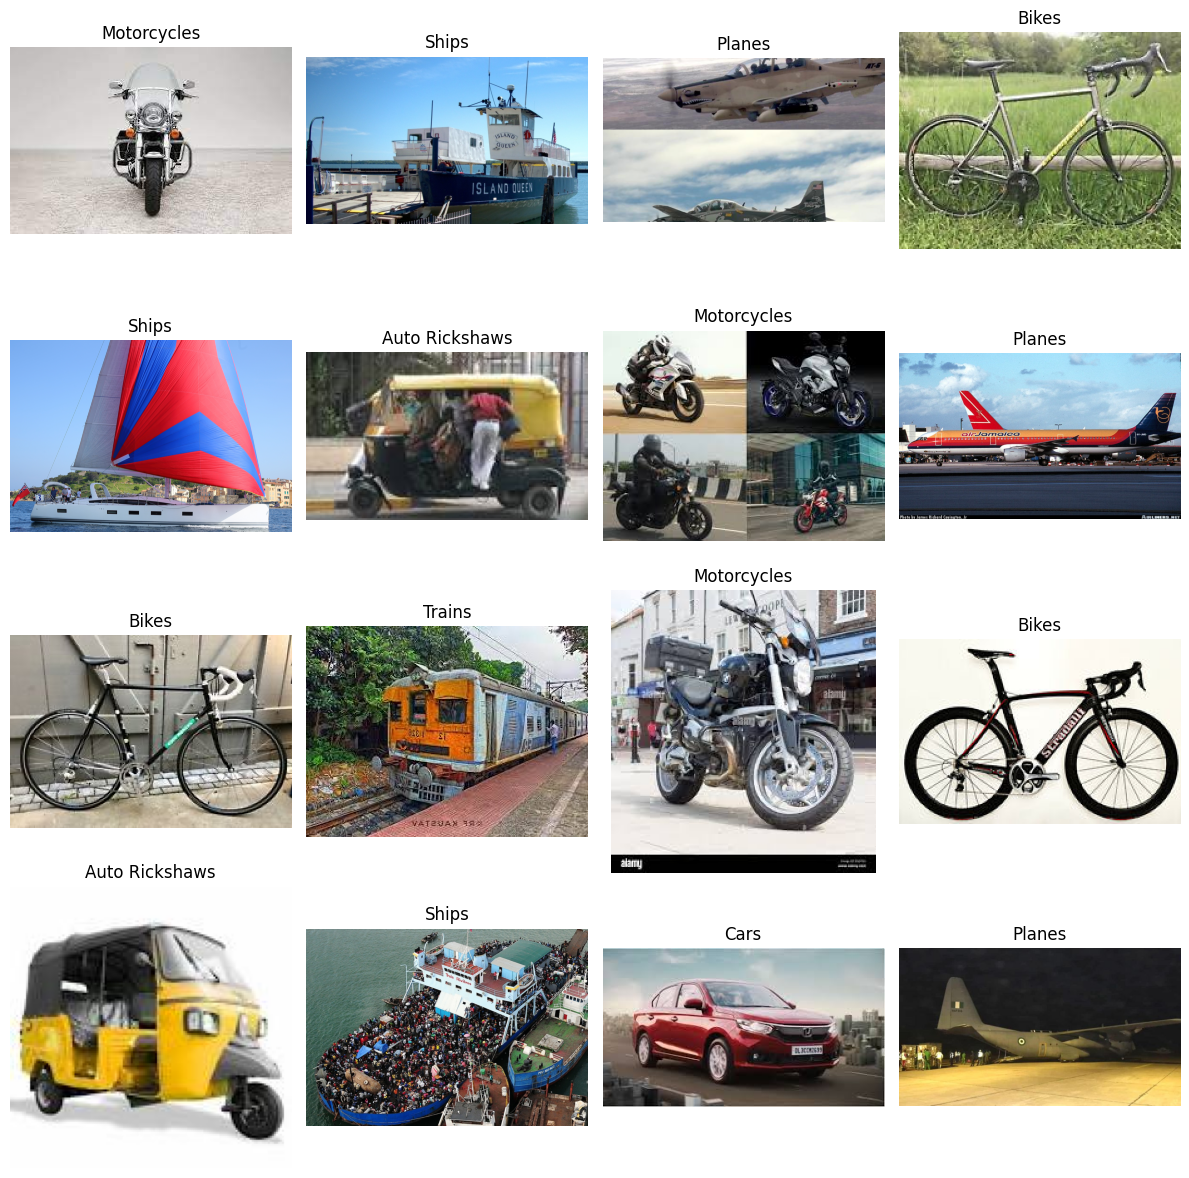

In [29]:
random_indices = random.sample(range(len(df)), 16)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    img = Image.open(df.iloc[idx]['path'])
    axes[i].imshow(img)
    axes[i].set_title(df.iloc[idx]['label'])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Mean and std calculation for this data

In [12]:
MEAN, STD = torch.Tensor([0.5085, 0.5154, 0.5126]), torch.Tensor([0.2933, 0.2841, 0.2978]) # get_mean_and_std(loader)

print(MEAN, STD)

tensor([0.5085, 0.5154, 0.5126]) tensor([0.2933, 0.2841, 0.2978])


## Data load

In [26]:
def load_data(train_dir: str, test_dir: str, config, mean: torch.Tensor, std: torch.Tensor, size: Tuple[int, int]) -> Tuple[DataLoader, DataLoader]:
    train_transforms = transforms.Compose([
        transforms.Resize(size),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    test_transforms = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    train_dataset = VehiclesDataset(train_dir, transforms=train_transforms)
    test_dataset = VehiclesDataset(test_dir, transforms=test_transforms)

    train_loader = DataLoader(train_dataset, batch_size=int(config["batch_size"]), shuffle=True, num_workers=2, pin_memory=True, persistent_workers=False)
    test_loader = DataLoader(test_dataset, batch_size=int(config["batch_size"]), shuffle=False, num_workers=2, pin_memory=True, persistent_workers=False)

    return train_loader, test_loader

## Defining models

In [14]:
class LeNetFive(nn.Module):

    def __init__(self, classes):
        super(LeNetFive, self).__init__()
        self.l1 = nn.Sequential(
            *self.make_layers(3, 6, kernel_size=5),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.l2 = nn.Sequential(
            *self.make_layers(6, 16, kernel_size=5),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, classes)
        )

    def make_layers(self, in_channels, out_channels, kernel_size, padding=0, stride=1):
        return [
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [15]:
class AlexNet(nn.Module):

    def __init__(self, classes, dropout_prob=0.5):
        super(AlexNet, self).__init__()
        
        self.features = nn.Sequential(
            *self.make_layers(3, 96, kernel_size=11, stride=4),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            *self.make_layers(96, 256, kernel_size=5, stride=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            *self.make_layers(256, 384, kernel_size=3, padding=1),
            *self.make_layers(384, 384, kernel_size=3, padding=1),
            *self.make_layers(384, 256, kernel_size=3, padding=1),
            
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(4096, classes)
        )

    def make_layers(self, in_channels, out_channels, kernel_size, padding=0, stride=1):
        return [
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

## Trainning loop

In [16]:
def train_epoch(model: nn.Module, train_loader: DataLoader, criterion: nn.Module, optimizer: optim.Optimizer, device: torch.device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for data, target in train_loader:
        data = data.float().to(device)
        target = target.long().to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)
    
    return total_loss / len(train_loader), 100. * correct / total


def test_epoch(model: nn.Module, test_loader: DataLoader, criterion: nn.Module, device: torch.device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data = data.float().to(device)
            target = target.long().to(device)

            output = model(data)
            loss = criterion(output, target)
            
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

    return total_loss / len(test_loader), 100. * correct / total


def evaluate(model: nn.Module, dir: DataLoader, size: Tuple[int, int], mean: torch.Tensor, std: torch.Tensor, device: torch.device):
    t = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    dataset = VehiclesDataset(os.path.join(DATA_DIR, dir), transforms=t)
    loader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=2)

    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in loader:
            data = data.float().to(device)
            target = target.long().to(device)

            output = model(data)

            pred = output.argmax(dim=1)
            
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    accuracy = (all_preds == all_targets).mean()
    precision_weighted = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
    recall_weighted = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
    f1_weighted = f1_score(all_targets, all_preds, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(all_targets, all_preds)

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision_weighted:.4f}")
    print(f"Recall:    {recall_weighted:.4f}")
    print(f"F1-Score:  {f1_weighted:.4f}")

    class_dict = dataset.classes

    classes = [name for name, idx in sorted(class_dict.items(), key=lambda x: x[1])]
        
    fig = go.Figure(data=go.Heatmap(
        z=conf_matrix,
        x=classes,
        y=classes,
        colorscale='Blues',
        text=conf_matrix,
        texttemplate='%{text}',
        textfont={"size": 12},
        colorbar=dict(title="Count")
    ))
    
    fig.update_layout(
        title='Confusion Matrix',
        xaxis_title='Predicted Label',
        yaxis_title='True Label',
        width=700,
        height=700
    )
    
    fig.show()

In [17]:
def plot_best_trial_metrics(experiment_path, metric="loss", mode="min"):
    df = pd.read_csv(experiment_path)

    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=('Loss', 'Accuracy')
    )

    fig.add_trace(
        go.Scatter(x=df['training_iteration'], y=df['train_loss'], 
                   mode='lines+markers', name='Train Loss'),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(x=df['training_iteration'], y=df['loss'], 
                   mode='lines+markers', name='Test Loss'),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(x=df['training_iteration'], y=df['train_accuracy'], 
                   mode='lines+markers', name='Train Accuracy'),
        row=1, col=2
    )

    fig.add_trace(
        go.Scatter(x=df['training_iteration'], y=df['accuracy'], 
                   mode='lines+markers', name='Test Accuracy'),
        row=1, col=2
    )

    fig.update_xaxes(title_text="Iteration", row=1, col=1)
    fig.update_xaxes(title_text="Iteration", row=1, col=2)
    fig.update_yaxes(title_text="Loss", row=1, col=1)
    fig.update_yaxes(title_text="Accuracy", row=1, col=2)

    fig.update_layout(height=500, width=1200, template='plotly_white', 
                      hovermode='x unified')

    fig.show()

In [18]:
def train_lenetfive_hp(config):
    train_loader, test_loader = load_data(
        train_dir=os.path.join(DATA_DIR, 'train'),
        test_dir=os.path.join(DATA_DIR, 'test'),
        config=config, mean=MEAN, std=STD, size=(32, 32)
    )
    
    model = LeNetFive(7)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config["weight_decay"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 2)
    
    epochs = config.get('epochs', 10)
    
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = test_epoch(model, test_loader, criterion, device)
        
        scheduler.step(test_loss)
        
        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {test_loss:.4f}, Val Acc: {test_acc:.2f}%')
        
        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            checkpoint_path = os.path.join(temp_checkpoint_dir, "checkpoint.pth")
            torch.save(model.state_dict(), checkpoint_path)
            
            tune.report(
                {"loss": test_loss, "accuracy": test_acc, "train_loss": train_loss, "train_accuracy": train_acc},
                checkpoint=Checkpoint.from_directory(temp_checkpoint_dir)
            )

lenetfive_config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "weight_decay": tune.loguniform(1e-6, 1e-2),
    "batch_size": tune.choice([32, 64]),
    "epochs": 10
}

In [19]:
scheduler = ASHAScheduler(
    metric="accuracy",
    mode="max",
    max_t=10,
    grace_period=1,
    reduction_factor=3
)

tuner = tune.Tuner(
    tune.with_resources(
        train_lenetfive_hp,
        resources={"cpu": 4, "gpu": 0.5}
    ),
    param_space=lenetfive_config,
    tune_config=tune.TuneConfig(
        scheduler=scheduler,
        num_samples=10
    )
)

lenetfive_results = tuner.fit()

best_result_lenetfive = lenetfive_results.get_best_result(metric="accuracy", mode="max")
print(f"\nBest trial config: {best_result_lenetfive.config}")
print(f"Best trial final validation accuracy: {best_result_lenetfive.metrics['accuracy']:.2f}%")
print(f"Best trial final validation loss: {best_result_lenetfive.metrics['loss']:.4f}")

(pid=gcs_server) [2025-11-05 11:29:40,381 E 37394 37394] (gcs_server) gcs_server.cc:302: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(raylet) [2025-11-05 11:29:43,427 E 37499 37499] (raylet) main.cc:975: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
[2025-11-05 11:29:48,475 E 35720 37550] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(train_lenetfive_hp pid=37969) [2025-11-05 11:29:53,188 E 37969 38063] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will

(train_lenetfive_hp pid=37968) Epoch 1/10
(train_lenetfive_hp pid=37968) Train Loss: 1.6596, Train Acc: 33.25%
(train_lenetfive_hp pid=37968) Val Loss: 1.4543, Val Acc: 43.27%


(train_lenetfive_hp pid=37968) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00000_0_batch_size=64,lr=0.0157,weight_decay=0.0065_2025-11-05_11-29-18/checkpoint_000000)
(train_lenetfive_hp pid=37968) [2025-11-05 11:29:53,165 E 37968 38029] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(train_lenetfive_hp pid=37968) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00000_0_batch_size=64,lr=0.0157,weight_decay=0.0065_2025-11-05_11-29-18/checkpoint_000001) [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplica

(train_lenetfive_hp pid=37968) Epoch 2/10 [repeated 2x across cluster]
(train_lenetfive_hp pid=37968) Train Loss: 1.4617, Train Acc: 42.30% [repeated 2x across cluster]
(train_lenetfive_hp pid=37968) Val Loss: 1.3749, Val Acc: 46.28% [repeated 2x across cluster]


(train_lenetfive_hp pid=37968) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00000_0_batch_size=64,lr=0.0157,weight_decay=0.0065_2025-11-05_11-29-18/checkpoint_000002) [repeated 2x across cluster]


(train_lenetfive_hp pid=37968) Epoch 3/10 [repeated 2x across cluster]
(train_lenetfive_hp pid=37968) Train Loss: 1.3958, Train Acc: 46.12% [repeated 2x across cluster]
(train_lenetfive_hp pid=37968) Val Loss: 1.3365, Val Acc: 49.24% [repeated 2x across cluster]


(train_lenetfive_hp pid=37968) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00000_0_batch_size=64,lr=0.0157,weight_decay=0.0065_2025-11-05_11-29-18/checkpoint_000003) [repeated 2x across cluster]


(train_lenetfive_hp pid=37968) Epoch 4/10 [repeated 2x across cluster]
(train_lenetfive_hp pid=37968) Train Loss: 1.3378, Train Acc: 48.35% [repeated 2x across cluster]
(train_lenetfive_hp pid=37968) Val Loss: 1.1832, Val Acc: 54.28% [repeated 2x across cluster]


(train_lenetfive_hp pid=37968) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00000_0_batch_size=64,lr=0.0157,weight_decay=0.0065_2025-11-05_11-29-18/checkpoint_000004) [repeated 2x across cluster]


(train_lenetfive_hp pid=37968) Epoch 5/10 [repeated 2x across cluster]
(train_lenetfive_hp pid=37968) Train Loss: 1.3179, Train Acc: 50.61% [repeated 2x across cluster]
(train_lenetfive_hp pid=37968) Val Loss: 1.5289, Val Acc: 45.53% [repeated 2x across cluster]
(train_lenetfive_hp pid=37968) Epoch 6/10 [repeated 2x across cluster]
(train_lenetfive_hp pid=37968) Train Loss: 1.2853, Train Acc: 51.74% [repeated 2x across cluster]
(train_lenetfive_hp pid=37968) Val Loss: 1.1795, Val Acc: 56.07% [repeated 2x across cluster]


(train_lenetfive_hp pid=37968) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00000_0_batch_size=64,lr=0.0157,weight_decay=0.0065_2025-11-05_11-29-18/checkpoint_000005) [repeated 2x across cluster]
(train_lenetfive_hp pid=37968) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00000_0_batch_size=64,lr=0.0157,weight_decay=0.0065_2025-11-05_11-29-18/checkpoint_000006) [repeated 2x across cluster]


(train_lenetfive_hp pid=37968) Epoch 7/10 [repeated 2x across cluster]
(train_lenetfive_hp pid=37968) Train Loss: 1.2472, Train Acc: 53.10% [repeated 2x across cluster]
(train_lenetfive_hp pid=37968) Val Loss: 1.1448, Val Acc: 56.58% [repeated 2x across cluster]
(train_lenetfive_hp pid=37969) Epoch 8/10 [repeated 2x across cluster]
(train_lenetfive_hp pid=37969) Train Loss: 1.0019, Train Acc: 64.42% [repeated 2x across cluster]
(train_lenetfive_hp pid=37969) Val Loss: 0.8392, Val Acc: 70.74% [repeated 2x across cluster]


(train_lenetfive_hp pid=37969) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00001_1_batch_size=32,lr=0.0101,weight_decay=0.0001_2025-11-05_11-29-18/checkpoint_000007) [repeated 2x across cluster]
(train_lenetfive_hp pid=37968) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00000_0_batch_size=64,lr=0.0157,weight_decay=0.0065_2025-11-05_11-29-18/checkpoint_000008) [repeated 2x across cluster]


(train_lenetfive_hp pid=37968) Epoch 9/10 [repeated 2x across cluster]
(train_lenetfive_hp pid=37968) Train Loss: 1.2310, Train Acc: 55.08% [repeated 2x across cluster]
(train_lenetfive_hp pid=37968) Val Loss: 1.2100, Val Acc: 54.19% [repeated 2x across cluster]


(train_lenetfive_hp pid=37968) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00000_0_batch_size=64,lr=0.0157,weight_decay=0.0065_2025-11-05_11-29-18/checkpoint_000009) [repeated 2x across cluster]


(train_lenetfive_hp pid=37968) Epoch 10/10 [repeated 2x across cluster]
(train_lenetfive_hp pid=37968) Train Loss: 1.2140, Train Acc: 55.21% [repeated 2x across cluster]
(train_lenetfive_hp pid=37968) Val Loss: 1.1053, Val Acc: 58.82% [repeated 2x across cluster]


(train_lenetfive_hp pid=38919) [2025-11-05 11:41:31,596 E 38919 39029] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(train_lenetfive_hp pid=37969) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00001_1_batch_size=32,lr=0.0101,weight_decay=0.0001_2025-11-05_11-29-18/checkpoint_000009)


(train_lenetfive_hp pid=38920) Epoch 1/10 [repeated 2x across cluster]
(train_lenetfive_hp pid=38920) Train Loss: 1.6468, Train Acc: 36.47% [repeated 2x across cluster]
(train_lenetfive_hp pid=38920) Val Loss: 1.3276, Val Acc: 50.74% [repeated 2x across cluster]


(train_lenetfive_hp pid=38920) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00002_2_batch_size=64,lr=0.0006,weight_decay=0.0000_2025-11-05_11-29-18/checkpoint_000000)
(train_lenetfive_hp pid=38920) [2025-11-05 11:41:31,580 E 38920 39009] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(train_lenetfive_hp pid=38919) Epoch 2/10 [repeated 2x across cluster]
(train_lenetfive_hp pid=38919) Train Loss: 1.1966, Train Acc: 55.83% [repeated 2x across cluster]
(train_lenetfive_hp pid=38919) Val Loss: 0.9867, Val Acc: 63.47% [repeated 2x across cluster]


(train_lenetfive_hp pid=38919) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00003_3_batch_size=64,lr=0.0013,weight_decay=0.0002_2025-11-05_11-29-18/checkpoint_000001) [repeated 2x across cluster]


(train_lenetfive_hp pid=38920) Epoch 3/10 [repeated 2x across cluster]
(train_lenetfive_hp pid=38920) Train Loss: 1.2113, Train Acc: 54.81% [repeated 2x across cluster]
(train_lenetfive_hp pid=38920) Val Loss: 1.0412, Val Acc: 62.38% [repeated 2x across cluster]


(train_lenetfive_hp pid=38920) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00002_2_batch_size=64,lr=0.0006,weight_decay=0.0000_2025-11-05_11-29-18/checkpoint_000002) [repeated 2x across cluster]


(train_lenetfive_hp pid=38919) Epoch 4/10 [repeated 2x across cluster]
(train_lenetfive_hp pid=38919) Train Loss: 1.0311, Train Acc: 62.49% [repeated 2x across cluster]
(train_lenetfive_hp pid=38919) Val Loss: 0.8665, Val Acc: 68.97% [repeated 2x across cluster]


(train_lenetfive_hp pid=38919) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00003_3_batch_size=64,lr=0.0013,weight_decay=0.0002_2025-11-05_11-29-18/checkpoint_000003) [repeated 2x across cluster]


(train_lenetfive_hp pid=38919) Epoch 5/10 [repeated 2x across cluster]
(train_lenetfive_hp pid=38919) Train Loss: 0.9510, Train Acc: 65.84% [repeated 2x across cluster]
(train_lenetfive_hp pid=38919) Val Loss: 0.8493, Val Acc: 69.52% [repeated 2x across cluster]


(train_lenetfive_hp pid=38919) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00003_3_batch_size=64,lr=0.0013,weight_decay=0.0002_2025-11-05_11-29-18/checkpoint_000004) [repeated 2x across cluster]


(train_lenetfive_hp pid=38919) Epoch 6/10 [repeated 2x across cluster]
(train_lenetfive_hp pid=38919) Train Loss: 0.9206, Train Acc: 67.14% [repeated 2x across cluster]
(train_lenetfive_hp pid=38919) Val Loss: 0.8109, Val Acc: 70.16% [repeated 2x across cluster]


(train_lenetfive_hp pid=38919) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00003_3_batch_size=64,lr=0.0013,weight_decay=0.0002_2025-11-05_11-29-18/checkpoint_000005) [repeated 2x across cluster]


(train_lenetfive_hp pid=38919) Epoch 7/10 [repeated 2x across cluster]
(train_lenetfive_hp pid=38919) Train Loss: 0.9053, Train Acc: 67.84% [repeated 2x across cluster]
(train_lenetfive_hp pid=38919) Val Loss: 0.8153, Val Acc: 71.04% [repeated 2x across cluster]


(train_lenetfive_hp pid=38919) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00003_3_batch_size=64,lr=0.0013,weight_decay=0.0002_2025-11-05_11-29-18/checkpoint_000006) [repeated 2x across cluster]


(train_lenetfive_hp pid=38919) Epoch 8/10 [repeated 2x across cluster]
(train_lenetfive_hp pid=38919) Train Loss: 0.8725, Train Acc: 68.18% [repeated 2x across cluster]
(train_lenetfive_hp pid=38919) Val Loss: 0.7308, Val Acc: 73.32% [repeated 2x across cluster]


(train_lenetfive_hp pid=38919) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00003_3_batch_size=64,lr=0.0013,weight_decay=0.0002_2025-11-05_11-29-18/checkpoint_000007) [repeated 2x across cluster]


(train_lenetfive_hp pid=38919) Epoch 9/10 [repeated 2x across cluster]
(train_lenetfive_hp pid=38919) Train Loss: 0.8444, Train Acc: 69.76% [repeated 2x across cluster]
(train_lenetfive_hp pid=38919) Val Loss: 0.7466, Val Acc: 72.38% [repeated 2x across cluster]


(train_lenetfive_hp pid=38919) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00003_3_batch_size=64,lr=0.0013,weight_decay=0.0002_2025-11-05_11-29-18/checkpoint_000008) [repeated 2x across cluster]


(train_lenetfive_hp pid=38919) Epoch 10/10 [repeated 2x across cluster]
(train_lenetfive_hp pid=38919) Train Loss: 0.8368, Train Acc: 70.51% [repeated 2x across cluster]
(train_lenetfive_hp pid=38919) Val Loss: 0.6664, Val Acc: 76.48% [repeated 2x across cluster]


(train_lenetfive_hp pid=38919) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00003_3_batch_size=64,lr=0.0013,weight_decay=0.0002_2025-11-05_11-29-18/checkpoint_000009) [repeated 2x across cluster]
(train_lenetfive_hp pid=41954) [2025-11-05 11:53:37,591 E 41954 42025] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(train_lenetfive_hp pid=38920) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00002_2_batch_size=64,lr=0.0006,weight_decay=0.0000_2025-11-05_11-29-18/checkpoint_000009)
(train_lenetfive_hp pid=41954) Checkpoint successfully created at: Checkpoint(fi

(train_lenetfive_hp pid=41954) Epoch 1/10 [repeated 2x across cluster]
(train_lenetfive_hp pid=41954) Train Loss: 1.4934, Train Acc: 42.11% [repeated 2x across cluster]
(train_lenetfive_hp pid=41954) Val Loss: 1.1797, Val Acc: 56.58% [repeated 2x across cluster]
(train_lenetfive_hp pid=41951) Epoch 2/10 [repeated 2x across cluster]
(train_lenetfive_hp pid=41951) Train Loss: 1.2290, Train Acc: 54.19% [repeated 2x across cluster]
(train_lenetfive_hp pid=41951) Val Loss: 1.0503, Val Acc: 62.40% [repeated 2x across cluster]


(train_lenetfive_hp pid=41951) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00004_4_batch_size=64,lr=0.0027,weight_decay=0.0012_2025-11-05_11-29-18/checkpoint_000001) [repeated 2x across cluster]


(train_lenetfive_hp pid=41951) Epoch 3/10 [repeated 2x across cluster]
(train_lenetfive_hp pid=41951) Train Loss: 1.1150, Train Acc: 58.82% [repeated 2x across cluster]
(train_lenetfive_hp pid=41951) Val Loss: 0.9836, Val Acc: 64.64% [repeated 2x across cluster]


(train_lenetfive_hp pid=41951) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00004_4_batch_size=64,lr=0.0027,weight_decay=0.0012_2025-11-05_11-29-18/checkpoint_000002) [repeated 2x across cluster]
(train_lenetfive_hp pid=42271) [2025-11-05 11:57:13,518 E 42271 42311] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(train_lenetfive_hp pid=41954) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00005_5_batch_size=64,lr=0.0034,weight_decay=0.0000_2025-11-05_11-29-18/checkpoint_000002)
(train_lenetfive_hp pid=41954) Checkpoint successfully created at: Checkpoint(fi

(train_lenetfive_hp pid=41954) Epoch 4/10 [repeated 2x across cluster]
(train_lenetfive_hp pid=41954) Train Loss: 1.0179, Train Acc: 62.88% [repeated 2x across cluster]
(train_lenetfive_hp pid=41954) Val Loss: 0.8658, Val Acc: 68.35% [repeated 2x across cluster]
(train_lenetfive_hp pid=42271) Epoch 1/10
(train_lenetfive_hp pid=42271) Train Loss: 1.4781, Train Acc: 42.36%
(train_lenetfive_hp pid=42271) Val Loss: 1.1452, Val Acc: 58.52%


(train_lenetfive_hp pid=42271) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00006_6_batch_size=32,lr=0.0019,weight_decay=0.0013_2025-11-05_11-29-18/checkpoint_000000)
(train_lenetfive_hp pid=41954) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00005_5_batch_size=64,lr=0.0034,weight_decay=0.0000_2025-11-05_11-29-18/checkpoint_000004)


(train_lenetfive_hp pid=41954) Epoch 5/10
(train_lenetfive_hp pid=41954) Train Loss: 0.9540, Train Acc: 65.86%
(train_lenetfive_hp pid=41954) Val Loss: 0.8806, Val Acc: 67.75%
(train_lenetfive_hp pid=42271) Epoch 2/10
(train_lenetfive_hp pid=42271) Train Loss: 1.2187, Train Acc: 53.70%
(train_lenetfive_hp pid=42271) Val Loss: 1.0687, Val Acc: 61.44%


(train_lenetfive_hp pid=42271) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00006_6_batch_size=32,lr=0.0019,weight_decay=0.0013_2025-11-05_11-29-18/checkpoint_000001)
(train_lenetfive_hp pid=41954) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00005_5_batch_size=64,lr=0.0034,weight_decay=0.0000_2025-11-05_11-29-18/checkpoint_000005)


(train_lenetfive_hp pid=41954) Epoch 6/10
(train_lenetfive_hp pid=41954) Train Loss: 0.9301, Train Acc: 66.95%
(train_lenetfive_hp pid=41954) Val Loss: 0.7354, Val Acc: 74.79%
(train_lenetfive_hp pid=42271) Epoch 3/10
(train_lenetfive_hp pid=42271) Train Loss: 1.1172, Train Acc: 59.20%
(train_lenetfive_hp pid=42271) Val Loss: 0.9736, Val Acc: 63.83%


(train_lenetfive_hp pid=42271) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00006_6_batch_size=32,lr=0.0019,weight_decay=0.0013_2025-11-05_11-29-18/checkpoint_000002)
(train_lenetfive_hp pid=42545) [2025-11-05 12:00:54,768 E 42545 42575] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(train_lenetfive_hp pid=41954) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00005_5_batch_size=64,lr=0.0034,weight_decay=0.0000_2025-11-05_11-29-18/checkpoint_000006)


(train_lenetfive_hp pid=41954) Epoch 7/10
(train_lenetfive_hp pid=41954) Train Loss: 0.8684, Train Acc: 69.01%
(train_lenetfive_hp pid=41954) Val Loss: 0.7178, Val Acc: 74.28%


(train_lenetfive_hp pid=42545) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00007_7_batch_size=64,lr=0.0007,weight_decay=0.0000_2025-11-05_11-29-18/checkpoint_000000)


(train_lenetfive_hp pid=42545) Epoch 1/10
(train_lenetfive_hp pid=42545) Train Loss: 1.6303, Train Acc: 36.20%
(train_lenetfive_hp pid=42545) Val Loss: 1.3370, Val Acc: 49.22%


(train_lenetfive_hp pid=42694) [2025-11-05 12:02:13,619 E 42694 42725] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(train_lenetfive_hp pid=41954) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00005_5_batch_size=64,lr=0.0034,weight_decay=0.0000_2025-11-05_11-29-18/checkpoint_000007)


(train_lenetfive_hp pid=41954) Epoch 8/10
(train_lenetfive_hp pid=41954) Train Loss: 0.8549, Train Acc: 69.86%
(train_lenetfive_hp pid=41954) Val Loss: 0.6824, Val Acc: 75.75%
(train_lenetfive_hp pid=42694) Epoch 1/10
(train_lenetfive_hp pid=42694) Train Loss: 1.8064, Train Acc: 28.83%
(train_lenetfive_hp pid=42694) Val Loss: 1.5910, Val Acc: 37.71%


(train_lenetfive_hp pid=42694) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00008_8_batch_size=64,lr=0.0002,weight_decay=0.0004_2025-11-05_11-29-18/checkpoint_000000)
(train_lenetfive_hp pid=45319) [2025-11-05 12:03:35,461 E 45319 45361] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(train_lenetfive_hp pid=41954) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00005_5_batch_size=64,lr=0.0034,weight_decay=0.0000_2025-11-05_11-29-18/checkpoint_000008)


(train_lenetfive_hp pid=41954) Epoch 9/10
(train_lenetfive_hp pid=41954) Train Loss: 0.8422, Train Acc: 69.36%
(train_lenetfive_hp pid=41954) Val Loss: 0.6926, Val Acc: 76.14%
(train_lenetfive_hp pid=45319) Epoch 1/10
(train_lenetfive_hp pid=45319) Train Loss: 1.7741, Train Acc: 28.90%
(train_lenetfive_hp pid=45319) Val Loss: 1.5464, Val Acc: 41.05%


(train_lenetfive_hp pid=45319) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00009_9_batch_size=32,lr=0.0002,weight_decay=0.0000_2025-11-05_11-29-18/checkpoint_000000)
2025-11-05 12:04:56,540	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10' in 0.0080s.
(train_lenetfive_hp pid=41954) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_lenetfive_hp_2025-11-05_11-29-10/train_lenetfive_hp_aacd7_00005_5_batch_size=64,lr=0.0034,weight_decay=0.0000_2025-11-05_11-29-18/checkpoint_000009)
2025-11-05 12:04:56,548	INFO tune.py:1041 -- Total run time: 2138.08 seconds (2137.94 seconds for the tuning loop).


(train_lenetfive_hp pid=41954) Epoch 10/10
(train_lenetfive_hp pid=41954) Train Loss: 0.8385, Train Acc: 69.94%
(train_lenetfive_hp pid=41954) Val Loss: 0.7086, Val Acc: 75.28%

Best trial config: {'lr': 0.001341377050834858, 'weight_decay': 0.0001734667739544081, 'batch_size': 64, 'epochs': 10}
Best trial final validation accuracy: 76.48%
Best trial final validation loss: 0.6664


In [20]:
best_checkpoint = best_result_lenetfive.checkpoint

model_lenetfive = LeNetFive(7)
with best_checkpoint.as_directory() as checkpoint_dir:
    checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")
    model_lenetfive.load_state_dict(torch.load(checkpoint_path))
    
model_lenetfive.to(device)

evaluate(model_lenetfive, 'test', (32, 32), MEAN, STD, device)

Accuracy:  0.7646
Precision: 0.7736
Recall:    0.7646
F1-Score:  0.7660


In [21]:
plot_best_trial_metrics(f"{best_result_lenetfive.path}/progress.csv")

In [22]:
def train_alexnet_hp(config):
    train_loader, test_loader = load_data(
        train_dir=os.path.join(DATA_DIR, 'train'),
        test_dir=os.path.join(DATA_DIR, 'test'),
        config=config, mean=MEAN, std=STD, size=(227, 227)
    )
    
    model = AlexNet(7, dropout_prob=config.get('dropout_prob', 0.5))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config["weight_decay"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 2)
    
    epochs = config.get('epochs', 10)
    
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = test_epoch(model, test_loader, criterion, device)
        
        scheduler.step(test_loss)
        
        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {test_loss:.4f}, Val Acc: {test_acc:.2f}%')
        
        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            checkpoint_path = os.path.join(temp_checkpoint_dir, "checkpoint.pth")
            torch.save(model.state_dict(), checkpoint_path)

            tune.report(
                {"loss": test_loss, "accuracy": test_acc, "train_loss": train_loss, "train_accuracy": train_acc},
                checkpoint=Checkpoint.from_directory(temp_checkpoint_dir)
            )

alexnet_config = {
    "dropout_prob": tune.uniform(0.1, 0.5),
    "lr": tune.loguniform(1e-5, 1e-2),
    "batch_size": tune.choice([32, 64, 128]),
    "weight_decay": tune.loguniform(1e-6, 1e-3),
    "epochs": 20
}

In [23]:
scheduler = ASHAScheduler(
    metric="accuracy",
    mode="max",
    max_t=20,
    grace_period=2,
    reduction_factor=3
)

tuner = tune.Tuner(
    tune.with_resources(
        train_alexnet_hp,
        resources={"cpu": 4, "gpu": 0.5}
    ),
    param_space=alexnet_config,
    tune_config=tune.TuneConfig(
        scheduler=scheduler,
        num_samples=10
    )
)

alexnet_results = tuner.fit()

best_result_alexnet = alexnet_results.get_best_result(metric="accuracy", mode="max")
print(f"\nBest trial config: {best_result_alexnet.config}")
print(f"Best trial final validation accuracy: {best_result_alexnet.metrics['accuracy']:.2f}%")
print(f"Best trial final validation loss: {best_result_alexnet.metrics['loss']:.4f}")

(train_alexnet_hp pid=47358) [2025-11-05 12:06:03,527 E 47358 47396] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(train_alexnet_hp pid=47357) Epoch 1/20
(train_alexnet_hp pid=47357) Train Loss: 1.3195, Train Acc: 50.20%
(train_alexnet_hp pid=47357) Val Loss: 0.8906, Val Acc: 68.10%


(train_alexnet_hp pid=47357) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00001_1_batch_size=32,dropout_prob=0.2984,lr=0.0000,weight_decay=0.0003_2025-11-05_12-05-27/checkpoint_000000)
(train_alexnet_hp pid=47357) [2025-11-05 12:06:03,549 E 47357 47430] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(train_alexnet_hp pid=47358) Epoch 2/20 [repeated 2x across cluster]
(train_alexnet_hp pid=47358) Train Loss: 1.8764, Train Acc: 19.99% [repeated 2x across cluster]
(train_alexnet_hp pid=47358) Val Loss: 1.7343, Val Acc: 25.70% [repeated 2x across cluster]


(train_alexnet_hp pid=47358) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00000_0_batch_size=32,dropout_prob=0.2404,lr=0.0015,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000001) [repeated 2x across cluster]


(train_alexnet_hp pid=47357) Epoch 3/20 [repeated 2x across cluster]
(train_alexnet_hp pid=47357) Train Loss: 0.7131, Train Acc: 74.09% [repeated 2x across cluster]
(train_alexnet_hp pid=47357) Val Loss: 0.5372, Val Acc: 80.72% [repeated 2x across cluster]


(train_alexnet_hp pid=47357) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00001_1_batch_size=32,dropout_prob=0.2984,lr=0.0000,weight_decay=0.0003_2025-11-05_12-05-27/checkpoint_000002) [repeated 2x across cluster]


(train_alexnet_hp pid=47357) Epoch 4/20 [repeated 2x across cluster]
(train_alexnet_hp pid=47357) Train Loss: 0.6406, Train Acc: 77.34% [repeated 2x across cluster]
(train_alexnet_hp pid=47357) Val Loss: 0.4404, Val Acc: 84.13% [repeated 2x across cluster]


(train_alexnet_hp pid=47357) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00001_1_batch_size=32,dropout_prob=0.2984,lr=0.0000,weight_decay=0.0003_2025-11-05_12-05-27/checkpoint_000003) [repeated 2x across cluster]


(train_alexnet_hp pid=47358) Epoch 5/20 [repeated 2x across cluster]
(train_alexnet_hp pid=47358) Train Loss: 1.5937, Train Acc: 32.75% [repeated 2x across cluster]
(train_alexnet_hp pid=47358) Val Loss: 1.4442, Val Acc: 38.37% [repeated 2x across cluster]


(train_alexnet_hp pid=47358) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00000_0_batch_size=32,dropout_prob=0.2404,lr=0.0015,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000004) [repeated 2x across cluster]


(train_alexnet_hp pid=47358) Epoch 6/20 [repeated 2x across cluster]
(train_alexnet_hp pid=47358) Train Loss: 1.5885, Train Acc: 34.90% [repeated 2x across cluster]
(train_alexnet_hp pid=47358) Val Loss: 1.4332, Val Acc: 39.13% [repeated 2x across cluster]


(train_alexnet_hp pid=47358) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00000_0_batch_size=32,dropout_prob=0.2404,lr=0.0015,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000005) [repeated 2x across cluster]


(train_alexnet_hp pid=47358) Epoch 7/20 [repeated 2x across cluster]
(train_alexnet_hp pid=47358) Train Loss: 1.5266, Train Acc: 36.94% [repeated 2x across cluster]
(train_alexnet_hp pid=47358) Val Loss: 1.4541, Val Acc: 41.18% [repeated 2x across cluster]


(train_alexnet_hp pid=47358) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00000_0_batch_size=32,dropout_prob=0.2404,lr=0.0015,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000006) [repeated 2x across cluster]


(train_alexnet_hp pid=47357) Epoch 8/20 [repeated 2x across cluster]
(train_alexnet_hp pid=47357) Train Loss: 0.4656, Train Acc: 83.29% [repeated 2x across cluster]
(train_alexnet_hp pid=47357) Val Loss: 0.3438, Val Acc: 87.74% [repeated 2x across cluster]


(train_alexnet_hp pid=47357) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00001_1_batch_size=32,dropout_prob=0.2984,lr=0.0000,weight_decay=0.0003_2025-11-05_12-05-27/checkpoint_000007) [repeated 2x across cluster]


(train_alexnet_hp pid=47357) Epoch 9/20 [repeated 2x across cluster]
(train_alexnet_hp pid=47357) Train Loss: 0.4444, Train Acc: 84.45% [repeated 2x across cluster]
(train_alexnet_hp pid=47357) Val Loss: 0.3254, Val Acc: 87.97% [repeated 2x across cluster]


(train_alexnet_hp pid=47357) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00001_1_batch_size=32,dropout_prob=0.2984,lr=0.0000,weight_decay=0.0003_2025-11-05_12-05-27/checkpoint_000008) [repeated 2x across cluster]


(train_alexnet_hp pid=47358) Epoch 9/20
(train_alexnet_hp pid=47358) Train Loss: 1.3964, Train Acc: 42.84%
(train_alexnet_hp pid=47358) Val Loss: 1.1153, Val Acc: 52.61%


(train_alexnet_hp pid=47358) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00000_0_batch_size=32,dropout_prob=0.2404,lr=0.0015,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000008)


(train_alexnet_hp pid=47357) Epoch 10/20
(train_alexnet_hp pid=47357) Train Loss: 0.4135, Train Acc: 85.29%
(train_alexnet_hp pid=47357) Val Loss: 0.2999, Val Acc: 89.25%


(train_alexnet_hp pid=47357) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00001_1_batch_size=32,dropout_prob=0.2984,lr=0.0000,weight_decay=0.0003_2025-11-05_12-05-27/checkpoint_000009)


(train_alexnet_hp pid=47357) Epoch 11/20 [repeated 2x across cluster]
(train_alexnet_hp pid=47357) Train Loss: 0.3864, Train Acc: 86.31% [repeated 2x across cluster]
(train_alexnet_hp pid=47357) Val Loss: 0.3013, Val Acc: 89.78% [repeated 2x across cluster]


(train_alexnet_hp pid=47357) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00001_1_batch_size=32,dropout_prob=0.2984,lr=0.0000,weight_decay=0.0003_2025-11-05_12-05-27/checkpoint_000010) [repeated 2x across cluster]


(train_alexnet_hp pid=47358) Epoch 11/20
(train_alexnet_hp pid=47358) Train Loss: 1.3423, Train Acc: 45.20%
(train_alexnet_hp pid=47358) Val Loss: 1.2129, Val Acc: 51.80%


(train_alexnet_hp pid=47358) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00000_0_batch_size=32,dropout_prob=0.2404,lr=0.0015,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000010)


(train_alexnet_hp pid=47357) Epoch 12/20
(train_alexnet_hp pid=47357) Train Loss: 0.3593, Train Acc: 87.44%
(train_alexnet_hp pid=47357) Val Loss: 0.2223, Val Acc: 92.24%


(train_alexnet_hp pid=47357) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00001_1_batch_size=32,dropout_prob=0.2984,lr=0.0000,weight_decay=0.0003_2025-11-05_12-05-27/checkpoint_000011)


(train_alexnet_hp pid=47358) Epoch 12/20
(train_alexnet_hp pid=47358) Train Loss: 1.2833, Train Acc: 47.80%
(train_alexnet_hp pid=47358) Val Loss: 1.5631, Val Acc: 45.92%


(train_alexnet_hp pid=47358) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00000_0_batch_size=32,dropout_prob=0.2404,lr=0.0015,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000011)


(train_alexnet_hp pid=47357) Epoch 13/20
(train_alexnet_hp pid=47357) Train Loss: 0.3440, Train Acc: 88.46%
(train_alexnet_hp pid=47357) Val Loss: 0.2152, Val Acc: 92.79%


(train_alexnet_hp pid=47357) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00001_1_batch_size=32,dropout_prob=0.2984,lr=0.0000,weight_decay=0.0003_2025-11-05_12-05-27/checkpoint_000012)


(train_alexnet_hp pid=47357) Epoch 14/20 [repeated 2x across cluster]
(train_alexnet_hp pid=47357) Train Loss: 0.3402, Train Acc: 88.10% [repeated 2x across cluster]
(train_alexnet_hp pid=47357) Val Loss: 0.2448, Val Acc: 91.85% [repeated 2x across cluster]


(train_alexnet_hp pid=47357) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00001_1_batch_size=32,dropout_prob=0.2984,lr=0.0000,weight_decay=0.0003_2025-11-05_12-05-27/checkpoint_000013) [repeated 2x across cluster]


(train_alexnet_hp pid=47357) Epoch 15/20 [repeated 2x across cluster]
(train_alexnet_hp pid=47357) Train Loss: 0.3149, Train Acc: 88.85% [repeated 2x across cluster]
(train_alexnet_hp pid=47357) Val Loss: 0.1709, Val Acc: 94.26% [repeated 2x across cluster]


(train_alexnet_hp pid=47357) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00001_1_batch_size=32,dropout_prob=0.2984,lr=0.0000,weight_decay=0.0003_2025-11-05_12-05-27/checkpoint_000014) [repeated 2x across cluster]


(train_alexnet_hp pid=47357) Epoch 16/20 [repeated 2x across cluster]
(train_alexnet_hp pid=47357) Train Loss: 0.3007, Train Acc: 89.30% [repeated 2x across cluster]
(train_alexnet_hp pid=47357) Val Loss: 0.1806, Val Acc: 93.84% [repeated 2x across cluster]


(train_alexnet_hp pid=47357) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00001_1_batch_size=32,dropout_prob=0.2984,lr=0.0000,weight_decay=0.0003_2025-11-05_12-05-27/checkpoint_000015) [repeated 2x across cluster]


(train_alexnet_hp pid=47357) Epoch 17/20 [repeated 2x across cluster]
(train_alexnet_hp pid=47357) Train Loss: 0.2823, Train Acc: 90.34% [repeated 2x across cluster]
(train_alexnet_hp pid=47357) Val Loss: 0.2802, Val Acc: 90.25% [repeated 2x across cluster]


(train_alexnet_hp pid=47357) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00001_1_batch_size=32,dropout_prob=0.2984,lr=0.0000,weight_decay=0.0003_2025-11-05_12-05-27/checkpoint_000016) [repeated 2x across cluster]


(train_alexnet_hp pid=47357) Epoch 18/20 [repeated 2x across cluster]
(train_alexnet_hp pid=47357) Train Loss: 0.2657, Train Acc: 90.78% [repeated 2x across cluster]
(train_alexnet_hp pid=47357) Val Loss: 0.1371, Val Acc: 95.09% [repeated 2x across cluster]


(train_alexnet_hp pid=47357) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00001_1_batch_size=32,dropout_prob=0.2984,lr=0.0000,weight_decay=0.0003_2025-11-05_12-05-27/checkpoint_000017) [repeated 2x across cluster]
(train_alexnet_hp pid=65661) [2025-11-05 12:31:58,582 E 65661 65704] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(train_alexnet_hp pid=47358) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00000_0_batch_size=32,dropout_prob=0.2404,lr=0.0015,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000017)


(train_alexnet_hp pid=47357) Epoch 19/20 [repeated 2x across cluster]
(train_alexnet_hp pid=47357) Train Loss: 0.2648, Train Acc: 90.77% [repeated 2x across cluster]
(train_alexnet_hp pid=47357) Val Loss: 0.2044, Val Acc: 92.73% [repeated 2x across cluster]


(train_alexnet_hp pid=47357) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00001_1_batch_size=32,dropout_prob=0.2984,lr=0.0000,weight_decay=0.0003_2025-11-05_12-05-27/checkpoint_000018)


(train_alexnet_hp pid=65661) Epoch 1/20
(train_alexnet_hp pid=65661) Train Loss: 2.6122, Train Acc: 25.70%
(train_alexnet_hp pid=65661) Val Loss: 1.4075, Val Acc: 39.05%


(train_alexnet_hp pid=65661) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00002_2_batch_size=32,dropout_prob=0.3085,lr=0.0011,weight_decay=0.0009_2025-11-05_12-05-27/checkpoint_000000)


(train_alexnet_hp pid=47357) Epoch 20/20
(train_alexnet_hp pid=47357) Train Loss: 0.2525, Train Acc: 91.54%
(train_alexnet_hp pid=47357) Val Loss: 0.1632, Val Acc: 94.05%


(train_alexnet_hp pid=47357) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00001_1_batch_size=32,dropout_prob=0.2984,lr=0.0000,weight_decay=0.0003_2025-11-05_12-05-27/checkpoint_000019)


(train_alexnet_hp pid=65661) Epoch 2/20
(train_alexnet_hp pid=65661) Train Loss: 1.4503, Train Acc: 40.55%
(train_alexnet_hp pid=65661) Val Loss: 2.2581, Val Acc: 38.64%


(train_alexnet_hp pid=65661) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00002_2_batch_size=32,dropout_prob=0.3085,lr=0.0011,weight_decay=0.0009_2025-11-05_12-05-27/checkpoint_000001)
(train_alexnet_hp pid=73488) [2025-11-05 12:34:55,057 E 73488 73538] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(train_alexnet_hp pid=74315) [2025-11-05 12:35:10,176 E 74315 74700] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(train_alexnet_hp pid=73488) Epoch 1/20
(train_alexnet_hp pid=73488) Train Loss: 80.1712, Train Acc: 16.55%
(train_alexnet_hp pid=73488) Val Loss: 1.9081, Val Acc: 20.67%


(train_alexnet_hp pid=73488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00003_3_batch_size=64,dropout_prob=0.1181,lr=0.0061,weight_decay=0.0002_2025-11-05_12-05-27/checkpoint_000000)


(train_alexnet_hp pid=74315) Epoch 1/20
(train_alexnet_hp pid=74315) Train Loss: 1.3077, Train Acc: 51.11%
(train_alexnet_hp pid=74315) Val Loss: 0.8507, Val Acc: 70.16%


(train_alexnet_hp pid=74315) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00004_4_batch_size=32,dropout_prob=0.1694,lr=0.0000,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000000)


(train_alexnet_hp pid=73488) Epoch 2/20
(train_alexnet_hp pid=73488) Train Loss: 1.9470, Train Acc: 18.77%
(train_alexnet_hp pid=73488) Val Loss: 1.8721, Val Acc: 21.11%


(train_alexnet_hp pid=73488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00003_3_batch_size=64,dropout_prob=0.1181,lr=0.0061,weight_decay=0.0002_2025-11-05_12-05-27/checkpoint_000001)


(train_alexnet_hp pid=74315) Epoch 2/20
(train_alexnet_hp pid=74315) Train Loss: 0.8667, Train Acc: 68.68%
(train_alexnet_hp pid=74315) Val Loss: 0.7282, Val Acc: 74.41%


(train_alexnet_hp pid=74315) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00004_4_batch_size=32,dropout_prob=0.1694,lr=0.0000,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000001)
(train_alexnet_hp pid=75655) [2025-11-05 12:37:55,752 E 75655 75685] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(train_alexnet_hp pid=75655) Epoch 1/20
(train_alexnet_hp pid=75655) Train Loss: 1.5587, Train Acc: 39.03%
(train_alexnet_hp pid=75655) Val Loss: 1.2888, Val Acc: 47.86%


(train_alexnet_hp pid=75655) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00005_5_batch_size=128,dropout_prob=0.3878,lr=0.0000,weight_decay=0.0010_2025-11-05_12-05-27/checkpoint_000000)


(train_alexnet_hp pid=74315) Epoch 3/20
(train_alexnet_hp pid=74315) Train Loss: 0.7150, Train Acc: 74.79%
(train_alexnet_hp pid=74315) Val Loss: 0.5439, Val Acc: 80.91%


(train_alexnet_hp pid=74315) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00004_4_batch_size=32,dropout_prob=0.1694,lr=0.0000,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000002)


(train_alexnet_hp pid=75655) Epoch 2/20
(train_alexnet_hp pid=75655) Train Loss: 1.0222, Train Acc: 63.05%
(train_alexnet_hp pid=75655) Val Loss: 0.7737, Val Acc: 72.28%


(train_alexnet_hp pid=75655) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00005_5_batch_size=128,dropout_prob=0.3878,lr=0.0000,weight_decay=0.0010_2025-11-05_12-05-27/checkpoint_000001)


(train_alexnet_hp pid=74315) Epoch 4/20
(train_alexnet_hp pid=74315) Train Loss: 0.6444, Train Acc: 77.17%
(train_alexnet_hp pid=74315) Val Loss: 0.4895, Val Acc: 83.05%


(train_alexnet_hp pid=74315) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00004_4_batch_size=32,dropout_prob=0.1694,lr=0.0000,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000003)


(train_alexnet_hp pid=75655) Epoch 3/20
(train_alexnet_hp pid=75655) Train Loss: 0.8277, Train Acc: 70.87%
(train_alexnet_hp pid=75655) Val Loss: 0.6817, Val Acc: 74.83%


(train_alexnet_hp pid=75655) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00005_5_batch_size=128,dropout_prob=0.3878,lr=0.0000,weight_decay=0.0010_2025-11-05_12-05-27/checkpoint_000002)


(train_alexnet_hp pid=74315) Epoch 5/20
(train_alexnet_hp pid=74315) Train Loss: 0.5637, Train Acc: 79.92%
(train_alexnet_hp pid=74315) Val Loss: 0.4109, Val Acc: 85.69%


(train_alexnet_hp pid=74315) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00004_4_batch_size=32,dropout_prob=0.1694,lr=0.0000,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000004)


(train_alexnet_hp pid=75655) Epoch 4/20
(train_alexnet_hp pid=75655) Train Loss: 0.6961, Train Acc: 75.14%
(train_alexnet_hp pid=75655) Val Loss: 0.6073, Val Acc: 77.76%


(train_alexnet_hp pid=75655) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00005_5_batch_size=128,dropout_prob=0.3878,lr=0.0000,weight_decay=0.0010_2025-11-05_12-05-27/checkpoint_000003)


(train_alexnet_hp pid=75655) Epoch 5/20 [repeated 2x across cluster]
(train_alexnet_hp pid=75655) Train Loss: 0.6079, Train Acc: 78.27% [repeated 2x across cluster]
(train_alexnet_hp pid=75655) Val Loss: 0.5208, Val Acc: 81.34% [repeated 2x across cluster]


(train_alexnet_hp pid=75655) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00005_5_batch_size=128,dropout_prob=0.3878,lr=0.0000,weight_decay=0.0010_2025-11-05_12-05-27/checkpoint_000004) [repeated 2x across cluster]


(train_alexnet_hp pid=74315) Epoch 7/20
(train_alexnet_hp pid=74315) Train Loss: 0.4894, Train Acc: 82.50%
(train_alexnet_hp pid=74315) Val Loss: 0.3854, Val Acc: 86.65%


(train_alexnet_hp pid=74315) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00004_4_batch_size=32,dropout_prob=0.1694,lr=0.0000,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000006)


(train_alexnet_hp pid=75655) Epoch 6/20
(train_alexnet_hp pid=75655) Train Loss: 0.5552, Train Acc: 80.33%
(train_alexnet_hp pid=75655) Val Loss: 0.4762, Val Acc: 83.28%


(train_alexnet_hp pid=75655) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00005_5_batch_size=128,dropout_prob=0.3878,lr=0.0000,weight_decay=0.0010_2025-11-05_12-05-27/checkpoint_000005)


(train_alexnet_hp pid=74315) Epoch 8/20
(train_alexnet_hp pid=74315) Train Loss: 0.4670, Train Acc: 83.41%
(train_alexnet_hp pid=74315) Val Loss: 0.3494, Val Acc: 87.42%


(train_alexnet_hp pid=74315) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00004_4_batch_size=32,dropout_prob=0.1694,lr=0.0000,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000007)
(train_alexnet_hp pid=80415) [2025-11-05 12:46:33,382 E 80415 80445] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(train_alexnet_hp pid=80415) Epoch 1/20
(train_alexnet_hp pid=80415) Train Loss: 1.3731, Train Acc: 47.41%
(train_alexnet_hp pid=80415) Val Loss: 1.2091, Val Acc: 58.20%


(train_alexnet_hp pid=80415) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00006_6_batch_size=128,dropout_prob=0.1279,lr=0.0001,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000000)


(train_alexnet_hp pid=80415) Epoch 2/20 [repeated 2x across cluster]
(train_alexnet_hp pid=80415) Train Loss: 0.8175, Train Acc: 69.94% [repeated 2x across cluster]
(train_alexnet_hp pid=80415) Val Loss: 0.6725, Val Acc: 75.99% [repeated 2x across cluster]


(train_alexnet_hp pid=80415) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00006_6_batch_size=128,dropout_prob=0.1279,lr=0.0001,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000001) [repeated 2x across cluster]


(train_alexnet_hp pid=74315) Epoch 10/20
(train_alexnet_hp pid=74315) Train Loss: 0.4091, Train Acc: 85.42%
(train_alexnet_hp pid=74315) Val Loss: 0.3136, Val Acc: 89.10%


(train_alexnet_hp pid=74315) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00004_4_batch_size=32,dropout_prob=0.1694,lr=0.0000,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000009)


(train_alexnet_hp pid=80415) Epoch 3/20
(train_alexnet_hp pid=80415) Train Loss: 0.6379, Train Acc: 77.45%
(train_alexnet_hp pid=80415) Val Loss: 0.5718, Val Acc: 80.00%


(train_alexnet_hp pid=80415) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00006_6_batch_size=128,dropout_prob=0.1279,lr=0.0001,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000002)


(train_alexnet_hp pid=74315) Epoch 11/20
(train_alexnet_hp pid=74315) Train Loss: 0.3803, Train Acc: 86.45%
(train_alexnet_hp pid=74315) Val Loss: 0.2702, Val Acc: 90.42%
(train_alexnet_hp pid=80415) Epoch 4/20
(train_alexnet_hp pid=80415) Train Loss: 0.5682, Train Acc: 79.71%
(train_alexnet_hp pid=80415) Val Loss: 0.5590, Val Acc: 80.06%


(train_alexnet_hp pid=80415) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00006_6_batch_size=128,dropout_prob=0.1279,lr=0.0001,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000003) [repeated 2x across cluster]


(train_alexnet_hp pid=80415) Epoch 5/20 [repeated 2x across cluster]
(train_alexnet_hp pid=80415) Train Loss: 0.5000, Train Acc: 82.64% [repeated 2x across cluster]
(train_alexnet_hp pid=80415) Val Loss: 0.4552, Val Acc: 84.20% [repeated 2x across cluster]


(train_alexnet_hp pid=80415) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00006_6_batch_size=128,dropout_prob=0.1279,lr=0.0001,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000004) [repeated 2x across cluster]


(train_alexnet_hp pid=74315) Epoch 13/20
(train_alexnet_hp pid=74315) Train Loss: 0.3661, Train Acc: 87.37%
(train_alexnet_hp pid=74315) Val Loss: 0.2208, Val Acc: 91.94%


(train_alexnet_hp pid=74315) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00004_4_batch_size=32,dropout_prob=0.1694,lr=0.0000,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000012)


(train_alexnet_hp pid=80415) Epoch 6/20
(train_alexnet_hp pid=80415) Train Loss: 0.4468, Train Acc: 83.80%
(train_alexnet_hp pid=80415) Val Loss: 0.4128, Val Acc: 85.35%


(train_alexnet_hp pid=80415) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00006_6_batch_size=128,dropout_prob=0.1279,lr=0.0001,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000005)


(train_alexnet_hp pid=74315) Epoch 14/20
(train_alexnet_hp pid=74315) Train Loss: 0.3265, Train Acc: 88.49%
(train_alexnet_hp pid=74315) Val Loss: 0.2355, Val Acc: 91.30%


(train_alexnet_hp pid=74315) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00004_4_batch_size=32,dropout_prob=0.1694,lr=0.0000,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000013)


(train_alexnet_hp pid=80415) Epoch 7/20
(train_alexnet_hp pid=80415) Train Loss: 0.4261, Train Acc: 85.13%
(train_alexnet_hp pid=80415) Val Loss: 0.3213, Val Acc: 89.12%


(train_alexnet_hp pid=80415) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00006_6_batch_size=128,dropout_prob=0.1279,lr=0.0001,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000006)


(train_alexnet_hp pid=74315) Epoch 15/20
(train_alexnet_hp pid=74315) Train Loss: 0.3228, Train Acc: 88.74%
(train_alexnet_hp pid=74315) Val Loss: 0.2200, Val Acc: 91.81%


(train_alexnet_hp pid=74315) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00004_4_batch_size=32,dropout_prob=0.1694,lr=0.0000,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000014)


(train_alexnet_hp pid=80415) Epoch 8/20
(train_alexnet_hp pid=80415) Train Loss: 0.3509, Train Acc: 87.81%
(train_alexnet_hp pid=80415) Val Loss: 0.2961, Val Acc: 89.25%


(train_alexnet_hp pid=80415) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00006_6_batch_size=128,dropout_prob=0.1279,lr=0.0001,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000007)


(train_alexnet_hp pid=74315) Epoch 16/20
(train_alexnet_hp pid=74315) Train Loss: 0.3036, Train Acc: 88.92%
(train_alexnet_hp pid=74315) Val Loss: 0.1824, Val Acc: 93.58%


(train_alexnet_hp pid=74315) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00004_4_batch_size=32,dropout_prob=0.1694,lr=0.0000,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000015)


(train_alexnet_hp pid=80415) Epoch 9/20
(train_alexnet_hp pid=80415) Train Loss: 0.3486, Train Acc: 88.24%
(train_alexnet_hp pid=80415) Val Loss: 0.4919, Val Acc: 83.07%


(train_alexnet_hp pid=80415) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00006_6_batch_size=128,dropout_prob=0.1279,lr=0.0001,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000008)


(train_alexnet_hp pid=74315) Epoch 17/20
(train_alexnet_hp pid=74315) Train Loss: 0.3008, Train Acc: 89.26%
(train_alexnet_hp pid=74315) Val Loss: 0.2464, Val Acc: 91.47%


(train_alexnet_hp pid=74315) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00004_4_batch_size=32,dropout_prob=0.1694,lr=0.0000,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000016)


(train_alexnet_hp pid=80415) Epoch 10/20
(train_alexnet_hp pid=80415) Train Loss: 0.3293, Train Acc: 88.33%
(train_alexnet_hp pid=80415) Val Loss: 0.3158, Val Acc: 88.93%


(train_alexnet_hp pid=80415) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00006_6_batch_size=128,dropout_prob=0.1279,lr=0.0001,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000009)


(train_alexnet_hp pid=74315) Epoch 18/20
(train_alexnet_hp pid=74315) Train Loss: 0.2817, Train Acc: 90.21%
(train_alexnet_hp pid=74315) Val Loss: 0.1542, Val Acc: 94.73%


(train_alexnet_hp pid=74315) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00004_4_batch_size=32,dropout_prob=0.1694,lr=0.0000,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000017)


(train_alexnet_hp pid=80415) Epoch 11/20
(train_alexnet_hp pid=80415) Train Loss: 0.3127, Train Acc: 88.64%
(train_alexnet_hp pid=80415) Val Loss: 0.3281, Val Acc: 88.82%


(train_alexnet_hp pid=80415) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00006_6_batch_size=128,dropout_prob=0.1279,lr=0.0001,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000010)


(train_alexnet_hp pid=74315) Epoch 19/20
(train_alexnet_hp pid=74315) Train Loss: 0.2699, Train Acc: 90.60%
(train_alexnet_hp pid=74315) Val Loss: 0.3323, Val Acc: 87.93%


(train_alexnet_hp pid=74315) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00004_4_batch_size=32,dropout_prob=0.1694,lr=0.0000,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000018)


(train_alexnet_hp pid=80415) Epoch 12/20
(train_alexnet_hp pid=80415) Train Loss: 0.2274, Train Acc: 92.27%
(train_alexnet_hp pid=80415) Val Loss: 0.1444, Val Acc: 95.29%


(train_alexnet_hp pid=80415) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00006_6_batch_size=128,dropout_prob=0.1279,lr=0.0001,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000011)


(train_alexnet_hp pid=74315) Epoch 20/20
(train_alexnet_hp pid=74315) Train Loss: 0.2724, Train Acc: 90.37%
(train_alexnet_hp pid=74315) Val Loss: 0.1505, Val Acc: 94.73%


(train_alexnet_hp pid=74315) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00004_4_batch_size=32,dropout_prob=0.1694,lr=0.0000,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000019)
(train_alexnet_hp pid=85360) [2025-11-05 13:03:49,868 E 85360 85402] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(train_alexnet_hp pid=80415) Epoch 13/20
(train_alexnet_hp pid=80415) Train Loss: 0.1910, Train Acc: 93.34%
(train_alexnet_hp pid=80415) Val Loss: 0.1285, Val Acc: 95.61%


(train_alexnet_hp pid=80415) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00006_6_batch_size=128,dropout_prob=0.1279,lr=0.0001,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000012)


(train_alexnet_hp pid=85360) Epoch 1/20
(train_alexnet_hp pid=85360) Train Loss: 2.0334, Train Acc: 30.19%
(train_alexnet_hp pid=85360) Val Loss: 1.8638, Val Acc: 28.88%


(train_alexnet_hp pid=85360) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00007_7_batch_size=128,dropout_prob=0.2732,lr=0.0002,weight_decay=0.0002_2025-11-05_12-05-27/checkpoint_000000)


(train_alexnet_hp pid=80415) Epoch 14/20
(train_alexnet_hp pid=80415) Train Loss: 0.1811, Train Acc: 94.01%
(train_alexnet_hp pid=80415) Val Loss: 0.1228, Val Acc: 95.71%


(train_alexnet_hp pid=80415) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00006_6_batch_size=128,dropout_prob=0.1279,lr=0.0001,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000013)


(train_alexnet_hp pid=85360) Epoch 2/20
(train_alexnet_hp pid=85360) Train Loss: 1.3202, Train Acc: 47.69%
(train_alexnet_hp pid=85360) Val Loss: 1.6169, Val Acc: 41.86%


(train_alexnet_hp pid=85360) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00007_7_batch_size=128,dropout_prob=0.2732,lr=0.0002,weight_decay=0.0002_2025-11-05_12-05-27/checkpoint_000001)


(train_alexnet_hp pid=80415) Epoch 15/20
(train_alexnet_hp pid=80415) Train Loss: 0.1743, Train Acc: 94.24%
(train_alexnet_hp pid=80415) Val Loss: 0.1132, Val Acc: 96.16%


(train_alexnet_hp pid=80415) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00006_6_batch_size=128,dropout_prob=0.1279,lr=0.0001,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000014)
(train_alexnet_hp pid=85742) [2025-11-05 13:06:49,821 E 85742 85772] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(train_alexnet_hp pid=85742) Epoch 1/20
(train_alexnet_hp pid=85742) Train Loss: 23.4553, Train Acc: 17.18%
(train_alexnet_hp pid=85742) Val Loss: 1.9444, Val Acc: 18.21%


(train_alexnet_hp pid=85742) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00008_8_batch_size=128,dropout_prob=0.2074,lr=0.0028,weight_decay=0.0004_2025-11-05_12-05-27/checkpoint_000000)


(train_alexnet_hp pid=80415) Epoch 16/20
(train_alexnet_hp pid=80415) Train Loss: 0.1631, Train Acc: 94.40%
(train_alexnet_hp pid=80415) Val Loss: 0.1057, Val Acc: 96.40%


(train_alexnet_hp pid=80415) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00006_6_batch_size=128,dropout_prob=0.1279,lr=0.0001,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000015)


(train_alexnet_hp pid=85742) Epoch 2/20
(train_alexnet_hp pid=85742) Train Loss: 1.9282, Train Acc: 18.54%
(train_alexnet_hp pid=85742) Val Loss: 1.8735, Val Acc: 19.85%


(train_alexnet_hp pid=85742) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00008_8_batch_size=128,dropout_prob=0.2074,lr=0.0028,weight_decay=0.0004_2025-11-05_12-05-27/checkpoint_000001)


(train_alexnet_hp pid=80415) Epoch 17/20
(train_alexnet_hp pid=80415) Train Loss: 0.1601, Train Acc: 94.58%
(train_alexnet_hp pid=80415) Val Loss: 0.1039, Val Acc: 96.44%


(train_alexnet_hp pid=80415) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00006_6_batch_size=128,dropout_prob=0.1279,lr=0.0001,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000016)
(train_alexnet_hp pid=85955) [2025-11-05 13:09:52,160 E 85955 85987] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(train_alexnet_hp pid=85955) Epoch 1/20
(train_alexnet_hp pid=85955) Train Loss: 2.0713, Train Acc: 28.29%
(train_alexnet_hp pid=85955) Val Loss: 1.5068, Val Acc: 35.94%


(train_alexnet_hp pid=85955) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00009_9_batch_size=32,dropout_prob=0.4808,lr=0.0006,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000000)


(train_alexnet_hp pid=80415) Epoch 18/20
(train_alexnet_hp pid=80415) Train Loss: 0.1605, Train Acc: 94.26%
(train_alexnet_hp pid=80415) Val Loss: 0.1076, Val Acc: 96.31%


(train_alexnet_hp pid=80415) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00006_6_batch_size=128,dropout_prob=0.1279,lr=0.0001,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000017)


(train_alexnet_hp pid=85955) Epoch 2/20
(train_alexnet_hp pid=85955) Train Loss: 1.4284, Train Acc: 42.73%
(train_alexnet_hp pid=85955) Val Loss: 1.5919, Val Acc: 39.86%


(train_alexnet_hp pid=85955) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00009_9_batch_size=32,dropout_prob=0.4808,lr=0.0006,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000001)


(train_alexnet_hp pid=80415) Epoch 19/20
(train_alexnet_hp pid=80415) Train Loss: 0.1542, Train Acc: 94.74%
(train_alexnet_hp pid=80415) Val Loss: 0.1029, Val Acc: 96.35%


(train_alexnet_hp pid=80415) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00006_6_batch_size=128,dropout_prob=0.1279,lr=0.0001,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000018)


(train_alexnet_hp pid=80415) Epoch 20/20
(train_alexnet_hp pid=80415) Train Loss: 0.1632, Train Acc: 94.40%
(train_alexnet_hp pid=80415) Val Loss: 0.0953, Val Acc: 96.69%


2025-11-05 13:13:43,147	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27' in 0.0085s.
2025-11-05 13:13:43,155	INFO tune.py:1041 -- Total run time: 4095.55 seconds (4095.50 seconds for the tuning loop).



Best trial config: {'dropout_prob': 0.12786874253182245, 'lr': 6.353229253738151e-05, 'batch_size': 128, 'weight_decay': 3.958856048952215e-06, 'epochs': 20}
Best trial final validation accuracy: 96.69%
Best trial final validation loss: 0.0953


In [24]:
best_checkpoint = best_result_alexnet.checkpoint

model_alexnet = AlexNet(7)
with best_checkpoint.as_directory() as checkpoint_dir:
    checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")
    model_alexnet.load_state_dict(torch.load(checkpoint_path))
    
model_alexnet.to(device)

evaluate(model_alexnet, 'test', (227, 227), MEAN, STD, device)

(train_alexnet_hp pid=80415) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/teamspace/studios/this_studio/ray_results/train_alexnet_hp_2025-11-05_12-05-27/train_alexnet_hp_b7b4c_00006_6_batch_size=128,dropout_prob=0.1279,lr=0.0001,weight_decay=0.0000_2025-11-05_12-05-27/checkpoint_000019)


Accuracy:  0.9669
Precision: 0.9672
Recall:    0.9669
F1-Score:  0.9669


In [25]:
plot_best_trial_metrics(f"{best_result_alexnet.path}/progress.csv")

## Conclusions

As a result of this homework, two classical neural networks (LeNet5 and AlexNet) were implemented and trained on PyTorch using the Ray hyperparameter optimization framework. LeNet5 achieved 75% accuracy on the test set, and AlexNet achieved 95%. It seems that the training was successful. Confusion matrices demonstrate the model's good generalization ability